# Generate the example process

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
from matplotlib import pyplot as plt

from deepalign.utils import microsoft_colors

from deepalign import EventLogGenerator
from deepalign.generation import CategoricalAttributeGenerator
from deepalign.generation.anomaly import *
from deepalign.processmining import EventLog

In [2]:
def plot(graph):
    pos = nx.drawing.nx_agraph.graphviz_layout(graph, prog='dot')
    fig = plt.figure(1, figsize=(8, 25))
    
    color_map = []
    for node in graph:
        if node in [EventLog.start_symbol, EventLog.end_symbol]:
            color_map.append(microsoft_colors[0])
        elif graph.nodes[node]['name'] == 'name':
            color_map.append(microsoft_colors[2])
        else:
            color_map.append(microsoft_colors[3])
    
    nx.draw(graph, pos, node_color=color_map)
    nx.draw_networkx_labels(graph, pos, labels=nx.get_node_attributes(graph, 'value'))
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=nx.get_edge_attributes(graph, 'probability'))

## Define the Likelihood Graph
Here we define the likelihood graph for the paper submission process. It will later be used to generate an event log by using a "random walk" throught he likelihood graph.

In [3]:
graph = nx.DiGraph()

nodes = [
    [EventLog.start_symbol, dict(value=EventLog.start_symbol, name='name')],
    
    [0, dict(value='Identify Problem', name='name')],
    [15, dict(value='Main Author', name='user')],
    [16, dict(value='Supervisor', name='user')],
    
    [1, dict(value='Research Related Work', name='name')],
    [17, dict(value='Main Author', name='user')],
    [18, dict(value='Student', name='user')],
    
    [2, dict(value='Develop Hypothesis', name='name')],
    [19, dict(value='Main Author', name='user')],
    [20, dict(value='Author', name='user')],
    
    [3, dict(value='Develop Method', name='name')],
    [21, dict(value='Main Author', name='user')],
    [22, dict(value='Author', name='user')],
    [23, dict(value='Student', name='user')],
    
    [4, dict(value='Experiment', name='name')],
    [24, dict(value='Main Author', name='user')],
    [25, dict(value='Author', name='user')],
    
    [5, dict(value='Experiment', name='name')],
    [26, dict(value='Main Author', name='user')],
    [27, dict(value='Author', name='user')],
    [28, dict(value='Student', name='user')],
    
    [6, dict(value='Conduct Study', name='name')],
    [29, dict(value='Main Author', name='user')],
    [30, dict(value='Author', name='user')],
    
    [7, dict(value='Evaluate', name='name')],
    [31, dict(value='Main Author', name='user')],
    [32, dict(value='Author', name='user')],
    
    [8, dict(value='Conclude', name='name')],
    [33, dict(value='Main Author', name='user')],
    
    [9, dict(value='Submit', name='name')],
    [34, dict(value='Main Author', name='user')],
    
    [10, dict(value='Review', name='name')],
    [35, dict(value='Reviewer', name='user')],
    
    [11, dict(value='Minor Revision', name='name')],
    [36, dict(value='Metareviewer', name='user')],
    
    [12, dict(value='Revise', name='name')],
    [37, dict(value='Main Author', name='user')],
    
    [13, dict(value='Submit', name='name')],
    [38, dict(value='Main Author', name='user')],
    
    [14, dict(value='Final Decision', name='name')],
    [39, dict(value='Metareviewer', name='user')],
    
    [EventLog.end_symbol, dict(value=EventLog.end_symbol, name='name')]
]

edges = [
    [EventLog.start_symbol, 0, 1.0],
    
    [0, 15, 0.9],
    [0, 16, 0.1],
    [15, 1, 1.0],
    [16, 1, 1.0],
    
    [1, 17, 0.3],
    [1, 18, 0.7],
    [17, 2, 0.6],
    [17, 3, 0.4],
    [18, 3, 1.0],
    
    [2, 19, 0.8],
    [2, 20, 0.2],
    [19, 4, 1.0],
    [20, 4, 1.0],
    
    [3, 21, 0.35],
    [3, 22, 0.2],
    [3, 23, 0.45],
    [21, 5, 1.0],
    [22, 5, 1.0],
    [23, 5, 1.0],
    
    [4, 24, 0.75],
    [4, 25, 0.25],
    [24, 6, 1.0],
    [25, 6, 1.0],
    
    [5, 26, 0.65],
    [5, 27, 0.1],
    [5, 28, 0.25],
    [26, 7, 1.0],
    [27, 7, 1.0],
    [28, 7, 1.0],
    
    [6, 29, 0.2],
    [6, 30, 0.8],
    [29, 8, 1.0],
    [30, 8, 1.0],
    
    [7, 31, 0.8],
    [7, 32, 0.2],
    [31, 8, 1.0],
    [32, 8, 1.0],
    
    [8, 33, 1.0],
    [33, 9, 1.0],
    
    [9, 34, 1.0],
    [34, 10, 1.0],
    
    [10, 35, 1.0],
    [35, 11, 0.75],
    [35, 14, 0.25],
    
    [11, 36, 1.0],
    [36, 12, 1.0],
    
    [12, 37, 1.0],
    [37, 13, 1.0],
    
    [13, 38, 1.0],
    [38, 14, 1.0],
    
    [14, 39, 1.0],
    
    [39, EventLog.end_symbol, 1.0]
]
graph.add_nodes_from(nodes)
graph.add_weighted_edges_from(edges, weight='probability')

## Basis for Figure 7 in the paper

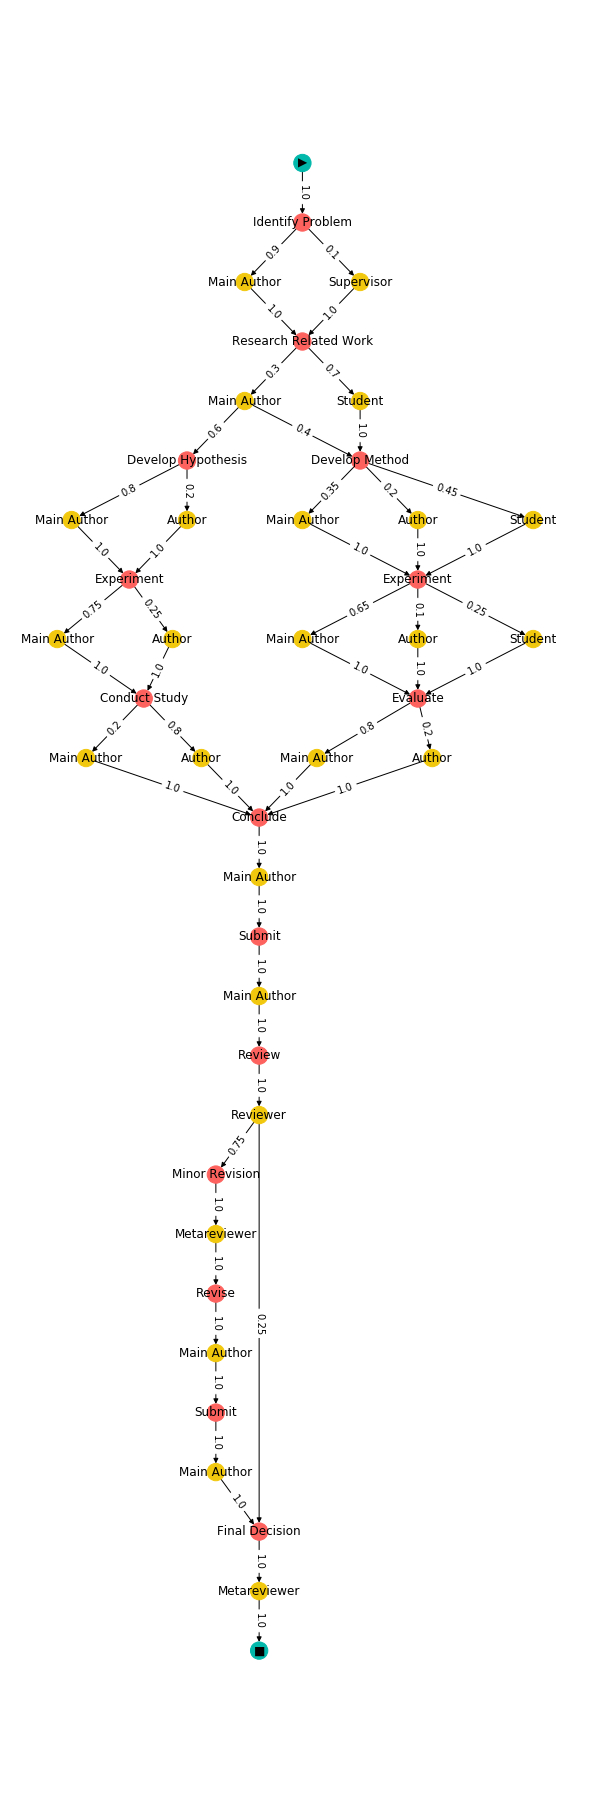

In [4]:
plot(graph)

## Generate Event Logs

Now we have to set up the `AttributeGenerator` to tell the `EventLogGenerator` about the possible values and the domain of `'user'`.

In [5]:
users = ['Main Author', 'Author', 'Student', 'Supervisor', 'Metareviewer', 'Reviewer']
user_generator = CategoricalAttributeGenerator(name='user', values=users)

anomalies = [
    SkipSequenceAnomaly(max_sequence_size=2),
    ReworkAnomaly(max_distance=5, max_sequence_size=3),
    EarlyAnomaly(max_distance=5, max_sequence_size=2),
    LateAnomaly(max_distance=5, max_sequence_size=2),
    InsertAnomaly(max_inserts=2),
    AttributeAnomaly(max_events=3, max_attributes=2)
]

No we can initialize and run the `EventLogGenerator` providing the `anomalies` from earlier and setting the `size` and `anomaly_p` parameters. The latter indicates that 30% of all cases will be affacted by one of the anomalies form `anomalies`.

In [6]:
generator = EventLogGenerator(event_attributes=[user_generator])

In [7]:
log = generator.generate(size=5000,
                         anomalies=anomalies,
                         anomaly_p=0.3,
                         likelihood_graph=graph,
                         seed=42)

Generate event log: 100%|██████████| 5000/5000 [00:13<00:00, 382.33it/s]


KeyError: 'Identify Problem->Research Related Work->Develop Method->Experiment->Evaluate->Conclude->Submit->Review->Minor Revision->Revise->Submit->Final Decision'

Now we just have to save the log.

In [ ]:
log.save('paper', p=0.3, number=1)

If we take a look at the first case in the log, we can see that the attributes were generated accordingly.

In [11]:
print(log[0])

Case 1: #events = 12
, label = normal
--------------------
Event 1: name = Identify Problem, timestamp = None, user = Supervisor
Event 2: name = Research Related Work, timestamp = None, user = Student
Event 3: name = Develop Method, timestamp = None, user = Main Author
Event 4: name = Experiment, timestamp = None, user = Student
Event 5: name = Evaluate, timestamp = None, user = Main Author
Event 6: name = Conclude, timestamp = None, user = Main Author
Event 7: name = Submit, timestamp = None, user = Main Author
Event 8: name = Review, timestamp = None, user = Reviewer
Event 9: name = Minor Revision, timestamp = None, user = Metareviewer
Event 10: name = Revise, timestamp = None, user = Main Author
Event 11: name = Submit, timestamp = None, user = Main Author
Event 12: name = Final Decision, timestamp = None, user = Metareviewer



## Adding case attributes

To add case attributes, we can load the event log from disk using the `EventLog.load` method.

In [12]:
log = EventLog.load('paper-0.3-1')

We create some lists that hold our case attribute values

In [13]:
decision = ['Accept', 'Weak accept', 'Borderline', 'Weak reject', 'Reject']
topic = ['Theory', 'Engineering']

Now, we can add the case attributes to the log based on the *Develop Method* and *Develop Hypothesis* activities as described in Sec. 4. If `topic` is `Theory`, this implies that *Develop Method* will occur in a case, whereas if the `topic` is `Engineering`, it implies *Develop Method* will occur.

In [14]:
for case in log:
    if 'Develop Hypothesis' in case.trace or 'Conduct Study' in case.trace:
        case.attributes['topic'] = 'Theory'
    elif 'Develop Method' in case.trace or 'Evaluate' in case.trace:
        case.attributes['topic'] = 'Engineering'
    else:
        case.attributes['topic'] = np.random.choice(topic)

We save it as a new event log.

In [16]:
log.save('paper', 0.3, 2)

We also want to make use of the `decision` case attribute. If the `decision` is either `Accept` or `Weak Accept`, there will be a *Minor Revision*, if the `decision` is `Weak Reject` or `Reject` there will be no `Minor Revision`. If the `decision` is `Borderline`, it can be both (ambiguity).

In [18]:
log = EventLog.load('paper-0.3-1')

for case in log:
    if 'Develop Hypothesis' in case.trace or 'Conduct Study' in case.trace:
        case.attributes['topic'] = 'Theory'
    elif 'Develop Method' in case.trace or 'Evaluate' in case.trace:
        case.attributes['topic'] = 'Engineering'
    else:
        case.attributes['topic'] = np.random.choice(topic)
    
    skipped = []
    if 'attr' in case.attributes['label']:
        if 'skipped' in case.attributes['label']['attr']:
            skipped = [e['name'] for e in case.attributes['label']['attr']['skipped']]
    if 'Minor Revision' in case.trace or 'Minor Revision' in skipped:
        random = np.random.choice(decision, p=[0.5, 0.3, 0.2, 0.0, 0.0])
        case.attributes['decision'] = random
    else:
        case.attributes['decision'] = np.random.choice(decision, p=[0.00, 0.0, 0.25, 0.5, 0.25])
        
log.save('paper', 0.3, 3)

For demonstration purposes, we also create an event log where this ambiguity does not exist.

In [19]:
log = EventLog.load('paper-0.3-1')

for case in log:
    if 'Develop Hypothesis' in case.trace or 'Conduct Study' in case.trace:
        case.attributes['topic'] = 'Theory'
    elif 'Develop Method' in case.trace or 'Evaluate' in case.trace:
        case.attributes['topic'] = 'Engineering'
    else:
        case.attributes['topic'] = np.random.choice(topic)
    
    skipped = []
    if 'attr' in case.attributes['label']:
        if 'skipped' in case.attributes['label']['attr']:
            skipped = [e['name'] for e in case.attributes['label']['attr']['skipped']]
    if 'Minor Revision' in case.trace or 'Minor Revision' in skipped:
        random = np.random.choice(decision, p=[0.6, 0.4, 0.0, 0.0, 0.0])
        case.attributes['decision'] = random
    else:
        case.attributes['decision'] = np.random.choice(decision, p=[0.00, 0.0, 0.25, 0.5, 0.25])
        
log.save('paper', 0.3, 4)